In [10]:
import os
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import models
from tqdm import tqdm

# ==========================================
# 1. Configuration
# ==========================================
CONFIG = {
    'data_dir': '../data',   
    'img_size': 224,
    'batch_size': 32,        
    'learning_rate': 0.0001,
    'epochs': 3,
    'seed': 42, # 이 시드값이 고정되어 있으므로 Val/Test 분할도 항상 고정됩니다.
    'device': torch.device("cuda" if torch.cuda.is_available() else "cpu")
}

torch.manual_seed(CONFIG['seed'])

# ==========================================
# 2. Dataset & Transforms
# ==========================================
class DeepDetectDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.image_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = cv2.imread(img_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        except:
            return torch.zeros((3, 224, 224)), torch.tensor(self.labels[idx], dtype=torch.float32)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented['image']
        
        return image, torch.tensor(self.labels[idx], dtype=torch.float32)

# [Transform 1] 증강 없음
basic_transform = A.Compose([
    A.Resize(height=CONFIG['img_size'], width=CONFIG['img_size'], interpolation=3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# [Transform 2] 증강 적용 (Train용)
aug_transform = A.Compose([
    A.Resize(height=CONFIG['img_size'], width=CONFIG['img_size'], interpolation=3),
    A.HorizontalFlip(p=0.5),
    A.GaussianBlur(blur_limit=(3, 7), p=0.2),
    A.ImageCompression(quality_lower=60, quality_upper=100, p=0.3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# [Validation/Test] 검증 및 테스트용 (증강 없음)
val_transform = A.Compose([
    A.Resize(height=CONFIG['img_size'], width=CONFIG['img_size'], interpolation=3),
    A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ToTensorV2()
])

# ==========================================
# 3. Helper Functions (수정된 로더 생성 로직)
# ==========================================
def load_file_paths(root_dir):
    """지정된 디렉토리에서 Real/Fake 이미지 경로를 모두 읽어오는 함수"""
    file_paths = []
    labels = []
    
    for label, class_name in enumerate(['Real', 'Fake']): # 0: Real, 1: Fake
        target_dir = os.path.join(root_dir, class_name)
        if not os.path.exists(target_dir): 
            target_dir = os.path.join(root_dir, class_name.lower()) # 소문자 호환
        
        if os.path.exists(target_dir):
            files = [os.path.join(target_dir, f) for f in os.listdir(target_dir) 
                     if f.lower().endswith(('.png','.jpg','.jpeg'))]
            file_paths.extend(files)
            labels.extend([label] * len(files))
    
    return file_paths, labels

def get_dataloaders(data_dir, train_transform_logic):
    # 1. 학습 데이터 로드 (../data/train 폴더 전체 사용)
    train_dir = os.path.join(data_dir, 'train')
    train_paths, train_labels = load_file_paths(train_dir)
    
    # 2. 테스트/검증 데이터 로드 (../data/test 폴더에서 가져옴)
    test_root_dir = os.path.join(data_dir, 'test')
    all_test_paths, all_test_labels = load_file_paths(test_root_dir)
    
    if len(train_paths) == 0 or len(all_test_paths) == 0:
        raise ValueError("데이터가 부족합니다. 경로를 확인해주세요.")

    # 3. Test 폴더 데이터를 50:50으로 Validation과 Test로 분할
    # random_state를 고정했으므로 항상 똑같은 파일이 Validation과 Test로 나뉩니다.
    val_paths, final_test_paths, val_labels, final_test_labels = train_test_split(
        all_test_paths, all_test_labels, 
        test_size=0.5,             # 50%는 Test, 나머지 50%는 Validation
        random_state=CONFIG['seed'], # 시드 고정 (중요!)
        stratify=all_test_labels   # 클래스 비율 유지
    )
    
    # 4. 데이터셋 생성
    # Train: 입력받은 transform 적용 (증강 or 미증강)
    train_dataset = DeepDetectDataset(train_paths, train_labels, transform=train_transform_logic)
    
    # Val & Test: 검증용 transform 적용 (단순 리사이즈)
    val_dataset = DeepDetectDataset(val_paths, val_labels, transform=val_transform)
    test_dataset = DeepDetectDataset(final_test_paths, final_test_labels, transform=val_transform)

    print(f"✅ 데이터셋 구성 완료")
    print(f"   - Train (from train folder): {len(train_dataset)}장")
    print(f"   - Val   (from test folder 50%): {len(val_dataset)}장")
    print(f"   - Test  (from test folder 50%): {len(test_dataset)}장")

    return {
        'train': DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2),
        'val': DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2),
        'test': DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)
    }

def get_resnet50_model():
    model = models.resnet50(pretrained=True)
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(model.fc.in_features, 1),
        nn.Sigmoid()
    )
    return model

def train(model, loaders, criterion, optimizer, epochs, save_name):
    model = model.to(CONFIG['device'])
    best_acc = 0.0
    print(f"🚀 학습 시작: {save_name}")

    for epoch in range(epochs):
        print(f"Epoch {epoch+1}/{epochs}")
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            corrects = 0
            total = 0
            
            loop = tqdm(loaders[phase], leave=True, mininterval=1.0)
            
            for inputs, labels in loop:
                inputs = inputs.to(CONFIG['device'])
                labels = labels.to(CONFIG['device']).float().unsqueeze(1)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    preds = (outputs > 0.5).float()

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                corrects += torch.sum(preds == labels.data)
                total += inputs.size(0)
                
                loop.set_description(f"[{phase}]")
                loop.set_postfix(loss=loss.item())

            epoch_loss = running_loss / total
            epoch_acc = corrects.double() / total
            
            print(f"[{phase}] Final Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            # Validation 성능이 최고일 때 저장
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), save_name)
                print(f"✅ Best Model Saved! Acc: {best_acc:.4f}")
        print("-" * 30)

In [13]:
# ==========================================
# 데이터 로더 미리 생성 (Loader Preparation)
# ==========================================
if os.path.exists(CONFIG['data_dir']):
    print("📦 데이터 로더 생성을 시작합니다...")

    # 1. 실험 1용 로더 (증강 없음: basic_transform)
    #    - Train 데이터가 깨끗한 상태로 유지됨
    print("\n[1/2] 실험 1용 로더 (No Augmentation) 생성 중...")
    loaders_no_aug = get_dataloaders(CONFIG['data_dir'], basic_transform)

    # 2. 실험 2용 로더 (증강 적용: aug_transform)
    #    [cite_start]- Train 데이터에 Blur, Compression 등이 적용됨 [cite: 82-87]
    print("\n[2/2] 실험 2용 로더 (With Augmentation) 생성 중...")
    loaders_aug = get_dataloaders(CONFIG['data_dir'], aug_transform)

    print("\n✅ 모든 데이터 로더 준비 완료!")
else:
    print("❌ 오류: 데이터 경로를 확인해주세요.")

📦 데이터 로더 생성을 시작합니다...

[1/2] 실험 1용 로더 (No Augmentation) 생성 중...
✅ 데이터셋 구성 완료
   - Train (from train folder): 90409장
   - Val   (from test folder 50%): 10888장
   - Test  (from test folder 50%): 10888장

[2/2] 실험 2용 로더 (With Augmentation) 생성 중...
✅ 데이터셋 구성 완료
   - Train (from train folder): 90409장
   - Val   (from test folder 50%): 10888장
   - Test  (from test folder 50%): 10888장

✅ 모든 데이터 로더 준비 완료!


In [2]:
# 실험 1 실행
if os.path.exists(CONFIG['data_dir']):
    print("🧪 실험 1: 데이터 증강 없음 (Basic Transform)")
    
    # 2. 모델 및 학습 설정
    model_no_aaug = get_resnet50_model()
    criterion = nn.BCELoss()
    optimizer_no_aug = optim.Adam(model_no_aug.parameters(), lr=CONFIG['learning_rate'])
    
    # 3. 학습 시작
    train(model_no_aug, loaders_no_aug, criterion, optimizer_no_aug, 
          CONFIG['epochs'], save_name='resnet50_no_aug.pth')
else:
    print("데이터 경로를 확인해주세요.")

🧪 실험 1: 데이터 증강 없음 (Basic Transform)
✅ 데이터셋 구성 완료
   - Train (from train folder): 90409장
   - Val   (from test folder 50%): 10888장
   - Test  (from test folder 50%): 10888장


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 학습 시작: resnet50_no_aug.pth
Epoch 1/3


[train]: 100%|████████████████| 2826/2826 [05:53<00:00,  7.99it/s, loss=0.00244]


[train] Final Loss: 0.0628 Acc: 0.9762


[val]: 100%|██████████████████████| 341/341 [00:22<00:00, 15.42it/s, loss=0.536]


[val] Final Loss: 1.1358 Acc: 0.6792
✅ Best Model Saved! Acc: 0.6792
------------------------------
Epoch 2/3


[train]: 100%|████████████████| 2826/2826 [04:52<00:00,  9.67it/s, loss=0.00414]


[train] Final Loss: 0.0196 Acc: 0.9932


[val]: 100%|███████████████████████| 341/341 [00:14<00:00, 23.16it/s, loss=1.29]


[val] Final Loss: 1.2813 Acc: 0.6906
✅ Best Model Saved! Acc: 0.6906
------------------------------
Epoch 3/3


[train]: 100%|██████████████████| 2826/2826 [04:49<00:00,  9.76it/s, loss=0.194]


[train] Final Loss: 0.0138 Acc: 0.9949


[val]: 100%|██████████████████████| 341/341 [00:14<00:00, 22.85it/s, loss=0.414]


[val] Final Loss: 1.2048 Acc: 0.7307
✅ Best Model Saved! Acc: 0.7307
------------------------------


In [6]:
# 실험 2 실행
if os.path.exists(CONFIG['data_dir']):
    print("🧪 실험 2: 데이터 증강 적용 (Blur, Compression, Flip)")
    
    # 2. 모델 및 학습 설정
    model_aug = get_resnet50_model()
    criterion = nn.BCELoss()
    optimizer_aug = optim.Adam(model_aug.parameters(), lr=CONFIG['learning_rate'])
    
    # 3. 학습 시작
    train(model_aug, loaders_aug, criterion, optimizer_aug, 
          CONFIG['epochs'], save_name='resnet50_with_aug.pth')
else:
    print("데이터 경로를 확인해주세요.")

🧪 실험 2: 데이터 증강 적용 (Blur, Compression, Flip)
✅ 데이터셋 구성 완료
   - Train (from train folder): 90409장
   - Val   (from test folder 50%): 10888장
   - Test  (from test folder 50%): 10888장


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


🚀 학습 시작: resnet50_with_aug.pth
Epoch 1/3


[train]: 100%|██████████████████| 2826/2826 [05:38<00:00,  8.36it/s, loss=0.615]


[train] Final Loss: 0.1137 Acc: 0.9548


[val]: 100%|█████████████████████| 341/341 [00:26<00:00, 12.68it/s, loss=0.0839]


[val] Final Loss: 0.4519 Acc: 0.8920
✅ Best Model Saved! Acc: 0.8920
------------------------------
Epoch 2/3


[train]: 100%|████████████████| 2826/2826 [05:55<00:00,  7.95it/s, loss=0.00797]


[train] Final Loss: 0.0488 Acc: 0.9823


[val]: 100%|█████████████████████| 341/341 [00:18<00:00, 18.25it/s, loss=0.0103]


[val] Final Loss: 0.4498 Acc: 0.9009
✅ Best Model Saved! Acc: 0.9009
------------------------------
Epoch 3/3


[train]: 100%|███████████████| 2826/2826 [05:50<00:00,  8.07it/s, loss=0.000549]


[train] Final Loss: 0.0359 Acc: 0.9868


[val]: 100%|███████████████████| 341/341 [00:17<00:00, 20.03it/s, loss=0.000878]


[val] Final Loss: 0.1526 Acc: 0.9617
✅ Best Model Saved! Acc: 0.9617
------------------------------


In [16]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import models
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc

# ==========================================
# 1. 모델 구조 정의 (ResNet-50)
# ==========================================
def get_resnet50_model():
    model = models.resnet50(pretrained=False) # 가중치는 따로 로드함
    num_ftrs = model.fc.in_features
    # [cite_start]논문 구조 [cite: 125-129]
    model.fc = nn.Sequential(
        nn.Dropout(p=0.5),
        nn.Linear(num_ftrs, 1),
        nn.Sigmoid()
    )
    return model

# ==========================================
# 2. 추론 엔진 (Inference Function)
# ==========================================
def run_inference(model_path, loader, device):
    print(f"🚀 모델 로딩 중... ({model_path})")
    
    # 모델 초기화 및 가중치 로드
    model = get_resnet50_model().to(device)
    
    if os.path.exists(model_path):
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
        except Exception as e:
            print(f"❌ 가중치 로드 에러: {e}")
            return None, None
    else:
        print(f"❌ 파일이 없습니다: {model_path}")
        return None, None

    model.eval()
    y_true, y_probs = [], []
    
    # 추론 루프
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating"):
            images = images.to(device)
            outputs = model(images).squeeze()
            
            # 배치 크기가 1일 때 차원 유지
            if outputs.ndim == 0: outputs = outputs.unsqueeze(0)
                
            probs = outputs.cpu().numpy()
            y_true.extend(labels.numpy())
            y_probs.extend(probs)
            
    return np.array(y_true), np.array(y_probs)

# ==========================================
# 3. 시각화 함수 (Visualization)
# ==========================================
def show_model_performance(y_true, y_probs, title):
    y_pred = (y_probs > 0.5).astype(int)
    
    # 지표 계산
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print("\n" + "="*60)
    print(f"📢 [{title}] 성능 리포트")
    print("="*60)
    print(f"✅ Accuracy : {acc*100:.2f}%")
    print(f"✅ F1 Score : {f1:.4f}")
    
    # 그래프 그리기
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    
    # (1) Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
                xticklabels=['Real', 'Fake'], yticklabels=['Real', 'Fake'])
    axes[0].set_title(f'{title}\nConfusion Matrix')
    axes[0].set_ylabel('Actual')
    axes[0].set_xlabel('Predicted')

    # (2) ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    axes[1].plot(fpr, tpr, color='darkorange', lw=2, label=f'AUC = {roc_auc:.3f}')
    axes[1].plot([0, 1], [0, 1], color='navy', linestyle='--')
    axes[1].set_title(f'{title}\nROC Curve')
    axes[1].legend(loc="lower right")

    # (3) Prediction Distribution
    axes[2].hist(y_probs[y_true==0], bins=50, alpha=0.5, label='Real', color='blue')
    axes[2].hist(y_probs[y_true==1], bins=50, alpha=0.5, label='Fake', color='red')
    axes[2].set_title(f'{title}\nPrediction Distribution')
    axes[2].legend()
    
    plt.tight_layout()

    # ==========================================
    # [추가됨] 이미지 저장 로직
    # ==========================================
    save_dir = './image'
    os.makedirs(save_dir, exist_ok=True) # 폴더가 없으면 생성
    
    # 파일명 생성 (공백 -> 언더바, 괄호 제거 등 파일명에 안 좋은 문자 정리)
    safe_title = title.replace(" ", "_").replace("(", "").replace(")", "")
    filename = f"{safe_title}.png"
    save_path = os.path.join(save_dir, filename)
    
    plt.savefig(save_path) # plt.show() 전에 저장해야 백지 현상 방지
    print(f"💾 그래프가 저장되었습니다: {save_path}")

    plt.show()

🧐 총 4번의 평가를 시작합니다.


🟦 [Model: No Augmentation Model] 평가 시작...
   ▶ Dataset: Validation Set (10888장)
🚀 모델 로딩 중... (resnet50_no_aug.pth)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_53175/3277830394.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio


📢 [No Augmentation Model on Validation Set] 성능 리포트
✅ Accuracy : 73.07%
✅ F1 Score : 0.7793
💾 그래프가 저장되었습니다: ./image/No_Augmentation_Model_on_Validation_Set.png


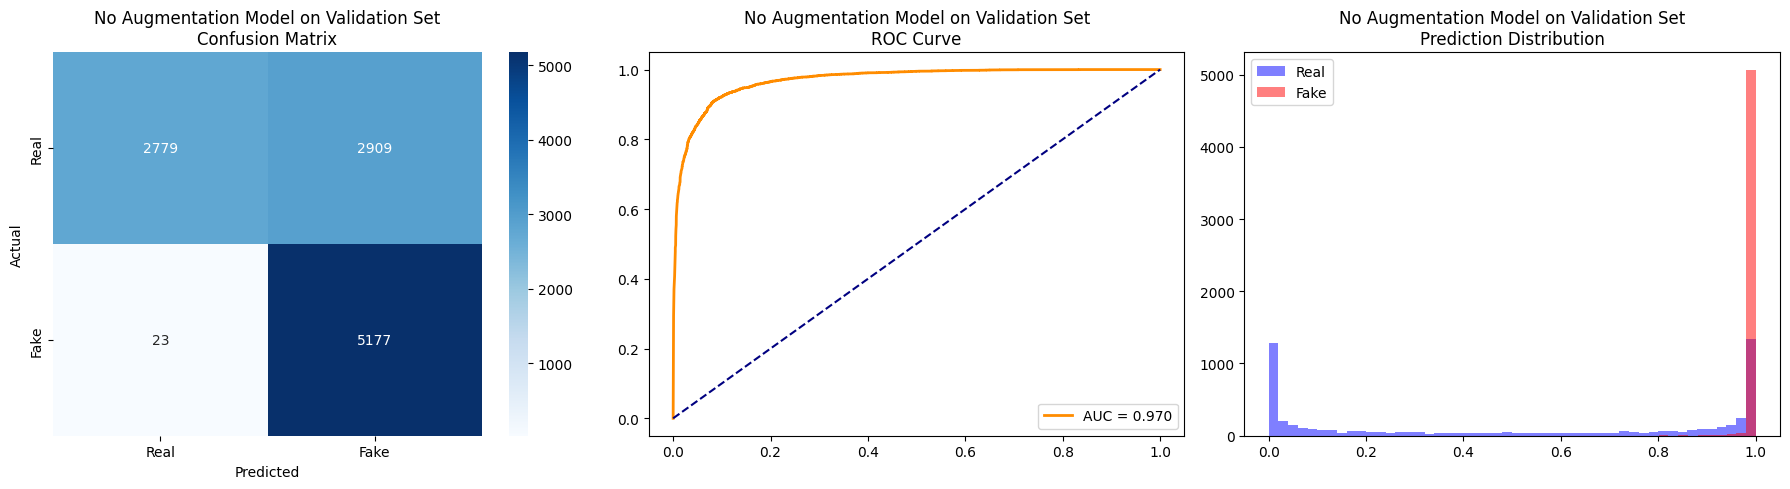

   ▶ Dataset: Test Set (10888장)
🚀 모델 로딩 중... (resnet50_no_aug.pth)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_53175/3277830394.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio


📢 [No Augmentation Model on Test Set] 성능 리포트
✅ Accuracy : 72.60%
✅ F1 Score : 0.7763
💾 그래프가 저장되었습니다: ./image/No_Augmentation_Model_on_Test_Set.png


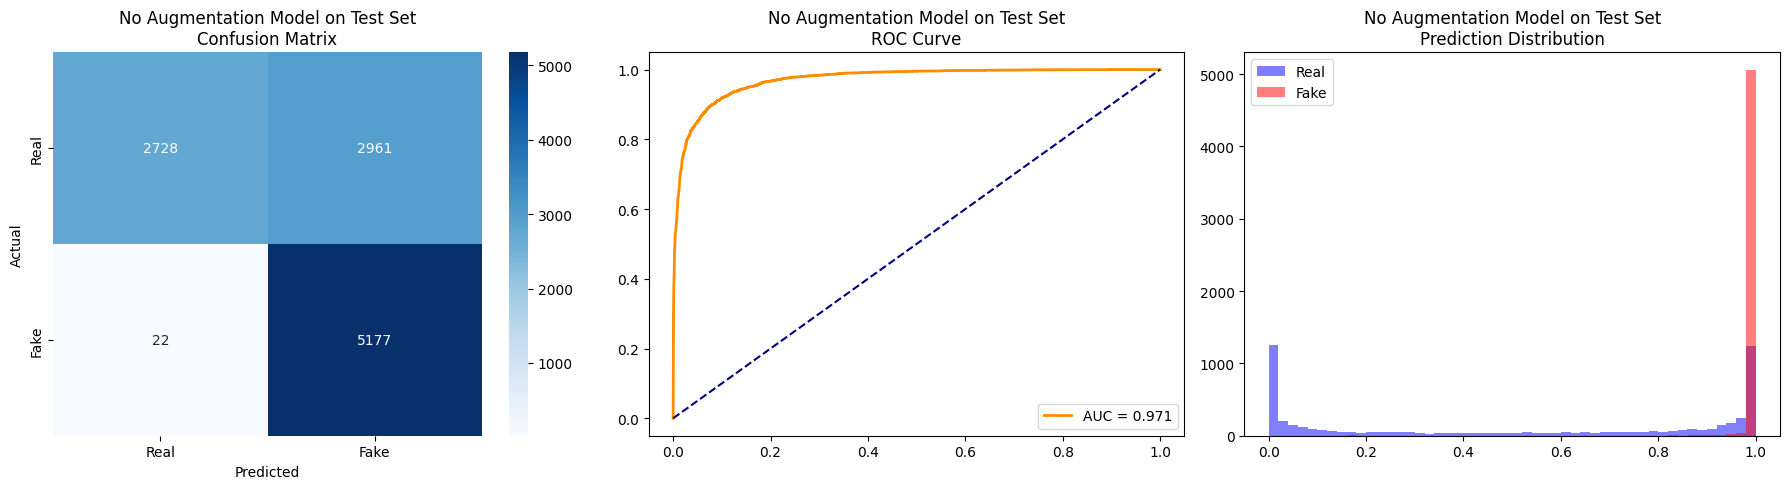

--------------------------------------------------------------------------------

🟦 [Model: With Augmentation Model] 평가 시작...
   ▶ Dataset: Validation Set (10888장)
🚀 모델 로딩 중... (resnet50_with_aug.pth)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_53175/3277830394.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio


📢 [With Augmentation Model on Validation Set] 성능 리포트
✅ Accuracy : 96.17%
✅ F1 Score : 0.9603
💾 그래프가 저장되었습니다: ./image/With_Augmentation_Model_on_Validation_Set.png


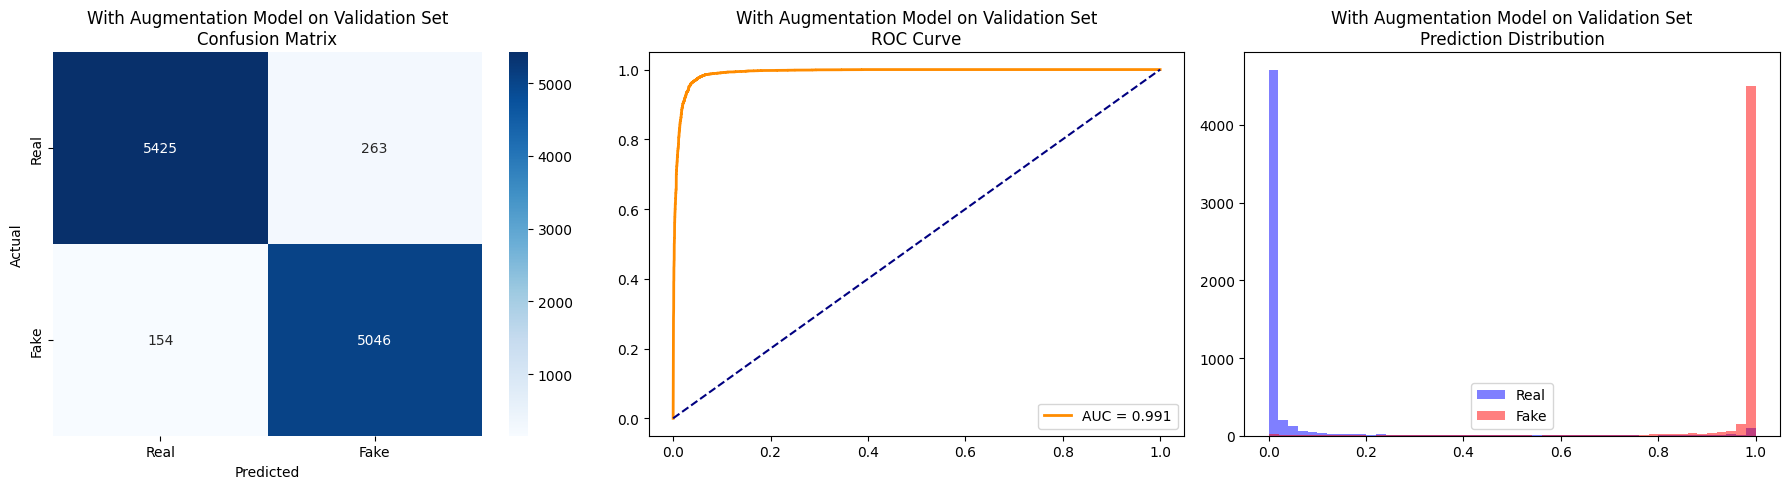

   ▶ Dataset: Test Set (10888장)
🚀 모델 로딩 중... (resnet50_with_aug.pth)


/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/tmp/ipykernel_53175/3277830394.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functio


📢 [With Augmentation Model on Test Set] 성능 리포트
✅ Accuracy : 96.32%
✅ F1 Score : 0.9619
💾 그래프가 저장되었습니다: ./image/With_Augmentation_Model_on_Test_Set.png


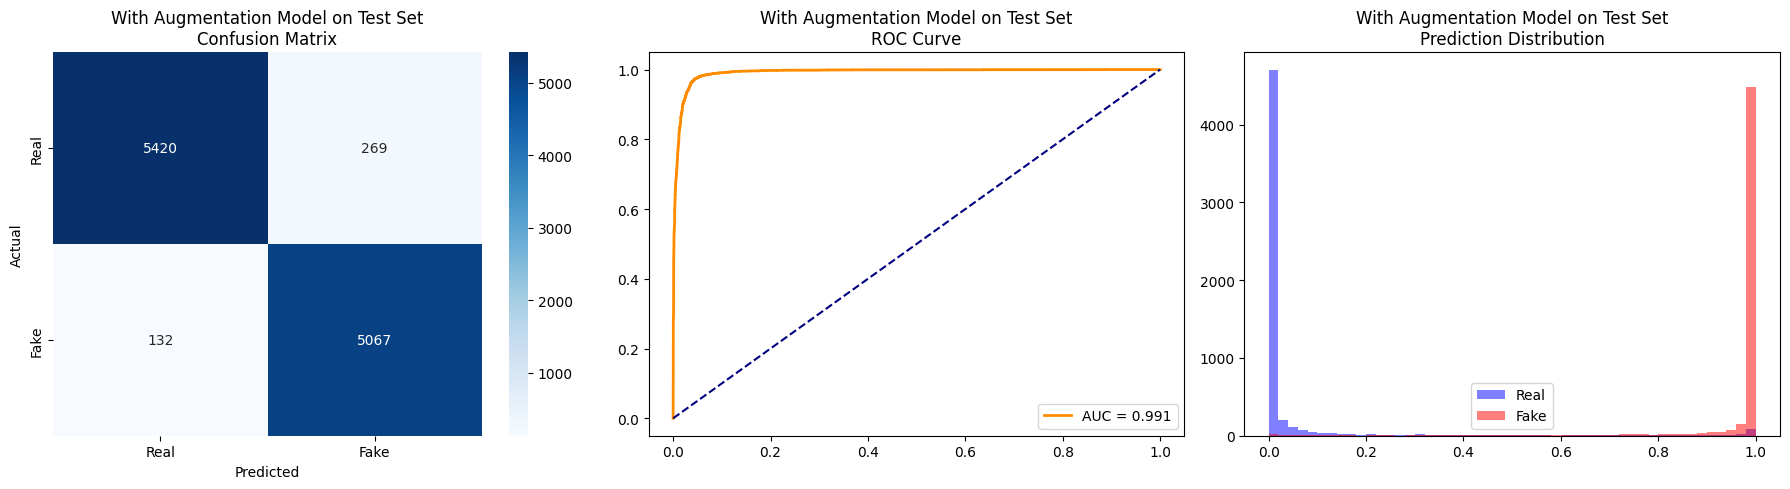

--------------------------------------------------------------------------------


In [17]:
# ==========================================
# 설정: 평가할 대상 목록
# ==========================================

# 1. 평가할 모델 파일들
target_models = [
    # (표시 이름, 파일 경로)
    ("No Augmentation Model", "resnet50_no_aug.pth"),
    ("With Augmentation Model", "resnet50_with_aug.pth")
]

# 2. 평가할 데이터셋 (loaders_aug에서 꺼내옴)
# 주의: get_dataloaders를 실행한 상태여야 합니다.
if 'loaders_aug' in locals():
    target_datasets = [
        ("Validation Set", loaders_aug['val']), 
        ("Test Set", loaders_aug['test'])
    ]
else:
    print("❌ Error: 'loaders_aug'가 정의되지 않았습니다. 데이터 로더 생성 셀을 먼저 실행해주세요.")
    target_datasets = []

# ==========================================
# 실행 Loop
# ==========================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

if target_datasets:
    print(f"🧐 총 {len(target_models) * len(target_datasets)}번의 평가를 시작합니다.\n")

    for model_name, model_path in target_models:
        print(f"\n🟦 [Model: {model_name}] 평가 시작...")
        
        for dataset_name, loader in target_datasets:
            # 그래프 제목 생성
            full_title = f"{model_name} on {dataset_name}"
            
            print(f"   ▶ Dataset: {dataset_name} ({len(loader.dataset)}장)")
            
            # 추론 및 시각화
            y_true, y_probs = run_inference(model_path, loader, device)
            
            if y_true is not None:
                show_model_performance(y_true, y_probs, title=full_title)
                
        print("-" * 80) # 모델 간 구분선